<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (GCC1932) - Trabalho 3</center></h1>

- Nome completo: Bianca Gallicchio Tavares
- [Link para vídeo](https://youtu.be/pR8AvE2IriM)

## 0 - Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Flatten, MaxPooling1D, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Configurações
plt.style.use('ggplot')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

## 1 - Carregando o dataset

In [13]:
def load_and_analyze(data_path, feature_dict_path):
    """Carrega dados e realiza análise exploratória"""
    # Carregamento
    with open(data_path, 'rb') as f:
        X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)
    
    feature_dict = pd.read_csv(feature_dict_path)
    
    # Análise de distribuição
    print("\nDistribuição dos Casos:")
    print(f"Total de casos (treino): {y_train.sum()}")
    print(f"Média semanal (treino): {y_train.mean():.2f}")
    print(f"Máximo em uma semana: {y_train.max()}")
    
    plt.figure(figsize=(10, 5))
    plt.hist(y_train, bins=50, alpha=0.7, label='Treino')
    plt.hist(y_val, bins=50, alpha=0.7, label='Validação')
    plt.hist(y_test, bins=50, alpha=0.7, label='Teste')
    plt.title('Distribuição dos Casos de Dengue')
    plt.legend()
    plt.show()
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_dict


Distribuição dos Casos:
Total de casos (treino): 47117
Média semanal (treino): 0.20
Máximo em uma semana: 337


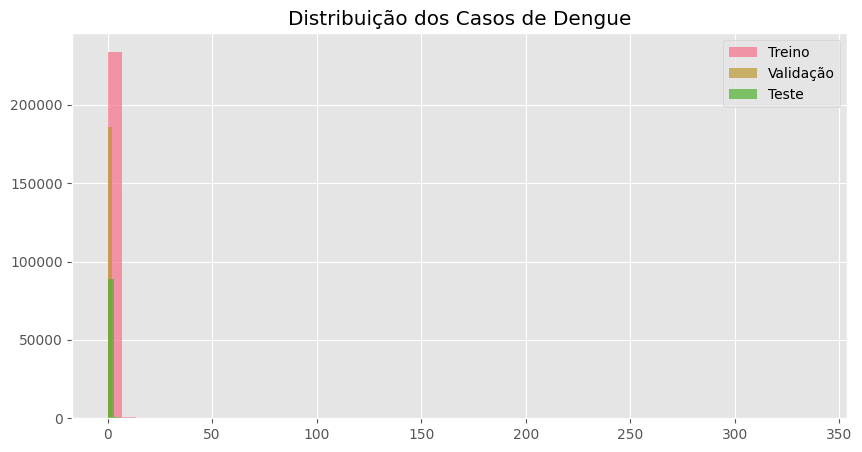

In [14]:
data_path = 'DATASETS/RJ_WEEKLY/dataset.pickle'
feature_dict_path = 'DATASETS/RJ_WEEKLY/feature_dictionary.csv'
X_train, y_train, X_val, y_val, X_test, y_test, feature_dict = load_and_analyze(data_path, feature_dict_path)

### Dicionário de Features

Este dicionário é gerado automaticamente durante a criação do dataset, baseado nas colunas do DataFrame final antes da conversão para NumPy.

1. **TEM_AVG**: Temperatura média diária (°C)
2. **TEM_MIN**: Temperatura mínima diária (°C)
3. **TEM_MAX**: Temperatura máxima diária (°C)
4. **RAIN**: Precipitação total diária (mm)
5. **RH_AVG**: Umidade relativa média do dia (%)
6. **RH_MIN**: Umidade relativa mínima do dia (%)
7. **RH_MAX**: Umidade relativa máxima do dia (%)
8. **IDEAL_TEMP**: Temperatura ideal para eclosão de ovos e amadurecimento do mosquito (°C)
9. **EXTREME_TEMP**: Temperatura nociva para o mosquito (°C)
10. **SIGNIFICANT_RAIN**: Chuva significativa capaz de criar novos criadouros (mm)
11. **EXTREME_RAIN**: Chuva extrema que remove ovos do ambiente (mm)
12. **TEMP_RANGE**: Amplitude térmica do dia (°C)
13. **WEEK_OF_YEAR**: Semana epidemiológica (1 a 52)
14. **TEM_AVG_MM_7**: Média móvel (ex: suavização de valores anteriores)
15. **CASES_MM_7**: Número de casos reportados
16. **CASES_ACC_7**: Número de casos reportados
17. **RAIN_ACC_7**: Valor acumulado (soma ao longo do tempo)
18. **RAIN_MM_7**: Média móvel (ex: suavização de valores anteriores)
19. **RH_MM_7**: Média móvel (ex: suavização de valores anteriores)
20. **TEMP_RANGE_MM_7**: Amplitude térmica do dia (°C)
21. **TEM_AVG_MM_14**: Média móvel (ex: suavização de valores anteriores)
22. **CASES_MM_14**: Número de casos reportados
23. **CASES_ACC_14**: Número de casos reportados
24. **RAIN_ACC_14**: Valor acumulado (soma ao longo do tempo)
25. **RAIN_MM_14**: Média móvel (ex: suavização de valores anteriores)
26. **RH_MM_14**: Média móvel (ex: suavização de valores anteriores)
27. **TEMP_RANGE_MM_14**: Amplitude térmica do dia (°C)
28. **TEM_AVG_MM_21**: Média móvel (ex: suavização de valores anteriores)
29. **CASES_MM_21**: Número de casos reportados
30. **CASES_ACC_21**: Número de casos reportados
31. **RAIN_ACC_21**: Valor acumulado (soma ao longo do tempo)
32. **RAIN_MM_21**: Média móvel (ex: suavização de valores anteriores)
33. **RH_MM_21**: Média móvel (ex: suavização de valores anteriores)
34. **TEMP_RANGE_MM_21**: Amplitude térmica do dia (°C)
35. **TEM_AVG_MM_28**: Média móvel (ex: suavização de valores anteriores)
36. **CASES_MM_28**: Número de casos reportados
37. **CASES_ACC_28**: Número de casos reportados
38. **RAIN_ACC_28**: Valor acumulado (soma ao longo do tempo)
39. **RAIN_MM_28**: Média móvel (ex: suavização de valores anteriores)
40. **RH_MM_28**: Média móvel (ex: suavização de valores anteriores)
41. **TEMP_RANGE_MM_28**: Amplitude térmica do dia (°C)
42. **CASES_LAG_1**: Número de casos reportados
43. **CASES_LAG_2**: Número de casos reportados
44. **CASES_LAG_3**: Número de casos reportados
45. **CASES_LAG_4**: Número de casos reportados
46. **CASES_LAG_5**: Número de casos reportados
47. **CASES_LAG_6**: Número de casos reportados

## 2 - Análise Exploratória

In [15]:
# Carregando o dicionário de features para entender as variáveis
feature_dict = pd.read_csv('DATASETS/RJ_WEEKLY/feature_dictionary.csv')
print("\nDicionário de Variáveis:")
print(feature_dict)


Dicionário de Variáveis:
    Index           Feature
0       0           TEM_AVG
1       1           TEM_MIN
2       2           TEM_MAX
3       3              RAIN
4       4            RH_AVG
5       5            RH_MIN
6       6            RH_MAX
7       7        CASES_MM_7
8       8       CASES_MM_14
9       9       CASES_MM_21
10     10       CASES_MM_28
11     11       CASES_ACC_7
12     12      CASES_ACC_14
13     13      CASES_ACC_21
14     14      CASES_ACC_28
15     15       CASES_LAG_1
16     16       CASES_LAG_2
17     17       CASES_LAG_3
18     18       CASES_LAG_4
19     19       CASES_LAG_5
20     20       CASES_LAG_6
21     21        IDEAL_TEMP
22     22      EXTREME_TEMP
23     23  SIGNIFICANT_RAIN
24     24      EXTREME_RAIN
25     25        TEMP_RANGE
26     26      WEEK_OF_YEAR
27     27      TEM_AVG_MM_7
28     28        RAIN_ACC_7
29     29         RAIN_MM_7
30     30           RH_MM_7
31     31   TEMP_RANGE_MM_7
32     32     TEM_AVG_MM_14
33     33       RAIN_A

In [16]:
# Verificando a dimensionalidade dos dados
print("\nDimensionalidade dos dados:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Dimensionalidade dos dados:
X_train shape: (235118, 47)
y_train shape: (235118,)


O dataset é **altamente desbalanceado**, com a maioria das observações registrando **zero casos** de dengue.  
Essa característica é comum em contextos epidemiológicos onde a maioria dos dias/unidades não apresentam surtos.

In [17]:
# Estatísticas de distribuição de classes
n_total = len(y_train)
n_positive = np.sum(y_train > 0)
n_zero = n_total - n_positive
pct_positive = (n_positive / n_total) * 100

print(f"Total de amostras: {n_total}")
print(f"Com casos (>0): {n_positive} ({pct_positive:.2f}%)")
print(f"Sem casos (=0): {n_zero} ({100 - pct_positive:.2f}%)")

Total de amostras: 235118
Com casos (>0): 7805 (3.32%)
Sem casos (=0): 227313 (96.68%)


In [18]:
# Transformando y em binário (1 = caso, 0 = sem caso)
y_train_bin = (y_train > 0).astype(int)
y_val_bin = (y_val > 0).astype(int)
y_test_bin = (y_test > 0).astype(int)

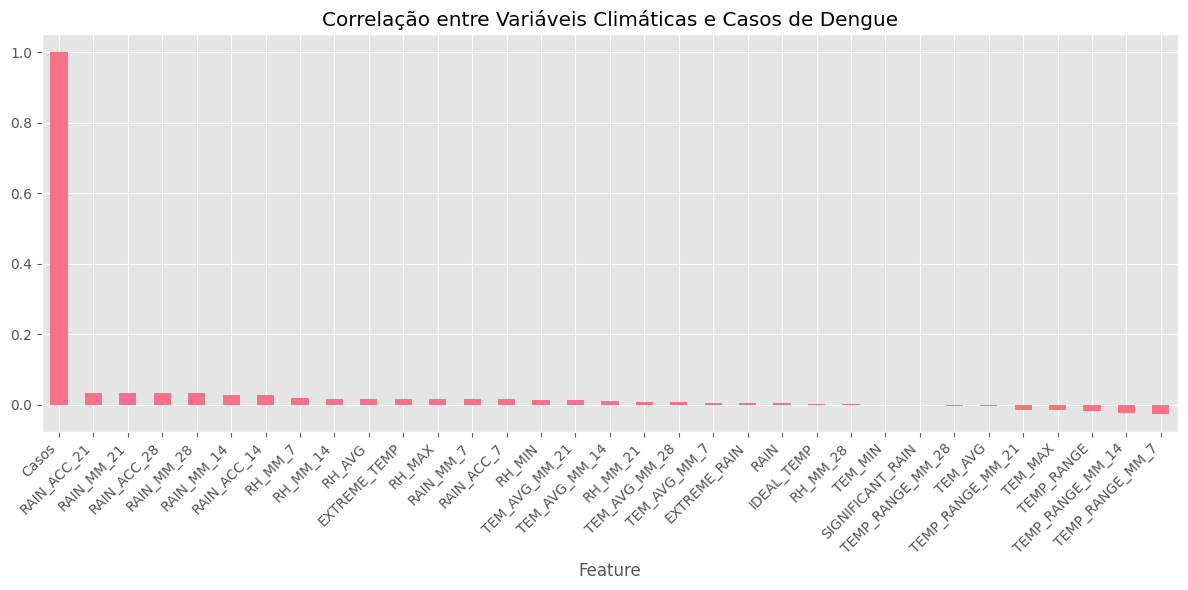


Top 10 variáveis CLIMÁTICAS mais correlacionadas com Casos de Dengue:
Feature
RAIN_ACC_21     0.032468
RAIN_MM_21      0.032468
RAIN_ACC_28     0.031881
RAIN_MM_28      0.031881
RAIN_MM_14      0.027074
RAIN_ACC_14     0.027074
RH_MM_7         0.018568
RH_MM_14        0.016504
RH_AVG          0.015392
EXTREME_TEMP    0.014736
Name: Casos, dtype: float64

Top 10 variáveis CLIMÁTICAS mais negativamente correlacionadas com Casos de Dengue:
Feature
WEEK_OF_YEAR       -0.031065
TEMP_RANGE_MM_7    -0.025737
TEMP_RANGE_MM_14   -0.023960
TEMP_RANGE         -0.017104
TEM_MAX            -0.015629
TEMP_RANGE_MM_21   -0.014926
TEM_AVG            -0.003996
TEMP_RANGE_MM_28   -0.003591
SIGNIFICANT_RAIN   -0.002144
TEM_MIN            -0.001036
Name: Casos, dtype: float64


In [19]:
# Correlações com variáveis climáticas
cases_related_vars = [
    'CASES_MM_7', 'CASES_ACC_7', 'CASES_MM_14', 'CASES_ACC_14',
    'CASES_MM_21', 'CASES_ACC_21', 'CASES_MM_28', 'CASES_ACC_28',
    'CASES_LAG_1', 'CASES_LAG_2', 'CASES_LAG_3', 'CASES_LAG_4',
    'CASES_LAG_5', 'CASES_LAG_6'
]
climate_vars = [f for f in feature_dict['Feature'] if f not in cases_related_vars]

df_train_climate = pd.DataFrame(X_train, columns=feature_dict['Feature'])
df_train_climate = df_train_climate[climate_vars]
df_train_climate['Casos'] = y_train

corr_matrix_climate = df_train_climate.corr()

plt.figure(figsize=(12, 6))
corr_matrix_climate['Casos'].sort_values(ascending=False)[:-1].plot(kind='bar')
plt.title('Correlação entre Variáveis Climáticas e Casos de Dengue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Mostrando as 10 variáveis climáticas mais correlacionadas
print("\nTop 10 variáveis CLIMÁTICAS mais correlacionadas com Casos de Dengue:")
print(corr_matrix_climate['Casos'].sort_values(ascending=False).head(11)[1:])  # Pula a correlação consigo mesmo

print("\nTop 10 variáveis CLIMÁTICAS mais negativamente correlacionadas com Casos de Dengue:")
print(corr_matrix_climate['Casos'].sort_values().head(10))

## 3 - Classificação Binária

### 3.1 Pré-processamento

#### Criando janelas temporais

In [20]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

window_size = 7

X_train_seq, y_train_seq = create_sequences(X_train, y_train_bin, window_size)
X_val_seq, y_val_seq = create_sequences(X_val, y_val_bin, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_bin, window_size)

#### Normalização

In [21]:
X_scaler = MinMaxScaler()

X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[2])
X_val_flat = X_val_seq.reshape(-1, X_val_seq.shape[2])
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[2])

X_scaler.fit(X_train_flat)

X_train_norm = X_scaler.transform(X_train_flat).reshape(X_train_seq.shape)
X_val_norm = X_scaler.transform(X_val_flat).reshape(X_val_seq.shape)
X_test_norm = X_scaler.transform(X_test_flat).reshape(X_test_seq.shape)

### 3.2 Modelo LSTM

In [23]:
lstm_model = Sequential([
    Input(shape=(window_size, X_train_norm.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Saída binária
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [24]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1),
    ModelCheckpoint('melhor_lstm_classificacao.keras', save_best_only=True, monitor='val_loss')
]

In [25]:
history_lstm = lstm_model.fit(
    X_train_norm, y_train_seq,
    validation_data=(X_val_norm, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9673 - loss: 0.1363 - precision_2: 0.5322 - recall_2: 0.0913 - val_accuracy: 0.9655 - val_loss: 0.1199 - val_precision_2: 0.6967 - val_recall_2: 0.2700 - learning_rate: 0.0010
Epoch 2/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9718 - loss: 0.1003 - precision_2: 0.7038 - recall_2: 0.2555 - val_accuracy: 0.9675 - val_loss: 0.1107 - val_precision_2: 0.7112 - val_recall_2: 0.3365 - learning_rate: 0.0010
Epoch 3/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9731 - loss: 0.0930 - precision_2: 0.7187 - recall_2: 0.3056 - val_accuracy: 0.9677 - val_loss: 0.1142 - val_precision_2: 0.6874 - val_recall_2: 0.3787 - learning_rate: 0.0010
Epoch 4/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9735 - loss: 0.0901 - precision_2: 0.7211 - recall_2: 0.3236 - val_accuracy: 0.9684 - val_loss: 0.1110 - val_precision_2: 0.7134 - val_recall_2: 0.3701 - learning_rate: 0.0010
Epoch 5/100
3674

### 3.3 Avaliação do Modelo

2853/2853 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     82278
           1       0.75      0.37      0.50      8990

    accuracy                           0.93     91268
   macro avg       0.84      0.68      0.73     91268
weighted avg       0.92      0.93      0.91     91268



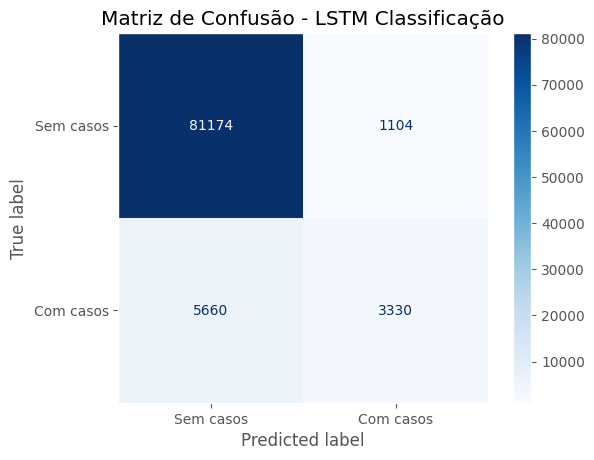

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = lstm_model.predict(X_test_norm).flatten()
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_seq, y_pred_labels))

cm = confusion_matrix(y_test_seq, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem casos', 'Com casos'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - LSTM Classificação")
plt.grid(False)
plt.show()

In [27]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    balanced_accuracy_score,
    f1_score
)

In [28]:
# AUC-ROC
roc_auc = roc_auc_score(y_test_seq, y_pred_probs)

# AUC-PR
pr_auc = average_precision_score(y_test_seq, y_pred_probs)

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test_seq, y_pred_labels)

# F1 Score
f1 = f1_score(y_test_seq, y_pred_labels)

print(f"\nMétricas adicionais:")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR : {pr_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")


Métricas adicionais:
AUC-ROC: 0.9032
AUC-PR : 0.6105
F1 Score: 0.4961
Balanced Accuracy: 0.6785


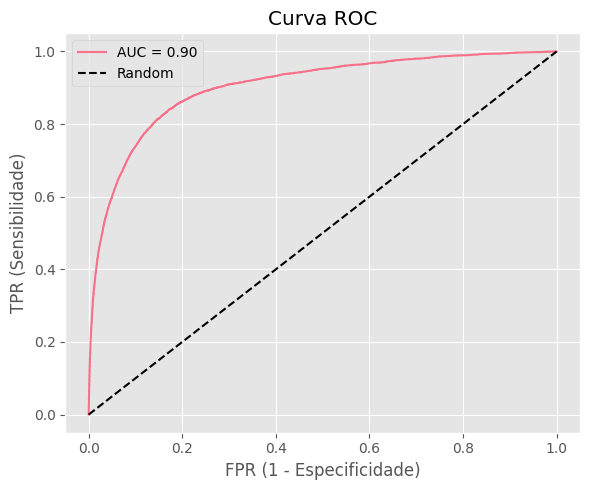

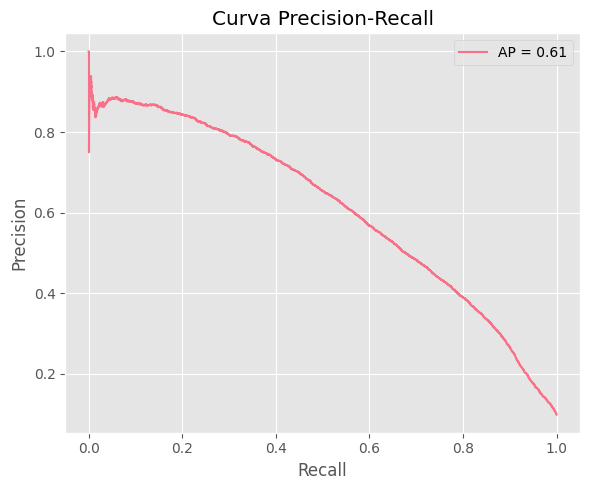

In [29]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_seq, y_pred_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Sensibilidade)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_seq, y_pred_probs)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Resumo Crítico

- O modelo é conservador: prefere errar por omissão (não prever dengue quando tem) do que por alarme falso.

- Ele é muito bom em evitar falsos positivos, mas perde muitos casos reais, o que pode ser crítico em contexto de saúde pública.

- O AUC-ROC alto indica que o modelo poderia ser calibrado para melhorar o recall, ajustando o threshold de decisão (por padrão é 0.5).